In [1]:
# import crap
import numpy as np
from netCDF4 import Dataset,num2date
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import cartopy
import cartopy.crs as ccrs

In [2]:
# Basic settings

itim = 36

datdir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/'

# constants
g = 9.8 # [m/s^2]
del_p = 50*10**2 # [Pa]

#### Read variables
---

In [3]:
# Read functions

def var_read_2d(datdir,varname,it_read):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][it_read,:,:,:]
    varfil_main.close()
    return var

def var_read_3d(datdir,varname,it_read):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][it_read,:,:,:]
    varfil_main.close()
    return var

In [4]:
# read in mixing ratios
q_list = ['QVAPOR','QICE', 'QSNOW', 'QGRAUP', 'QCLOUD', 'QRAIN']
q_var = np.empty((6,20,740,1200)) # specific humidity type x level x lat x lon
for var in range(len(q_list)):
    q_var[var,:,:,:] = var_read_3d(datdir,q_list[var],itim)
    # with Dataset(file, 'r') as nc:
    #     q_var[var,:,:,:] = nc.variables[q_list[var]][itim,:,:,:] # hour 36 only; time x level x lat x lon
    #     nc.close()
qrain = var_read_3d(datdir,'QRAIN',itim)

In [5]:
# Original (Rosi's) classification scheme

# read in postprocessed classification
file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/strat.nc'
# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/haiyan/memb_01/ncrf/post/d02/strat.nc'
varfil_main = Dataset(datdir+'strat.nc')
c_type_og = varfil_main.variables['strat'][itim,:,:,:]
varfil_main.close()
c_type_og = np.squeeze(c_type_og)

In [6]:
# Additional variables for plotting

# Radiative tendencies
varname='RTHRATLW'
lw = var_read_3d(datdir,varname,itim)
varname='RTHRATLWC'
lwc = var_read_3d(datdir,varname,itim)
varname='RTHRATSW'
sw = var_read_3d(datdir,varname,itim)
varname='RTHRATSWC'
swc = var_read_3d(datdir,varname,itim)
crf = sw + lw - lwc - swc
crf *= 3600*24 # K/s --> K/d

# Vertical motion
file = datdir+'W.nc'
nc = Dataset(file, 'r')
w_wind = nc.variables['W'][itim,:,:,:]
pres = nc.variables['pres'][:]
nz = pres.shape[0]
nc.close()

In [7]:
# Moist and dry static energy (MSE, DSE); saved up to 100 hPa
varfil_main = Dataset(datdir+'mse.nc')
amse = varfil_main.variables['mse_int'][itim,:,:] # J/m2, vertically integrated
varfil_main.close()

# For MSE variance terms
lw_t = var_read_2d(datdir,'LWUPT',itim) - var_read_2d(datdir,'LWDNT',itim) # W/m2
lw_b = var_read_2d(datdir,'LWUPB',itim) - var_read_2d(datdir,'LWDNB',itim) # W/m2
lw_net = lw_b - lw_t

lw_tc = var_read_2d(datdir,'LWUPTC',itim) - var_read_2d(datdir,'LWDNTC',itim) # W/m2
lw_bc = var_read_2d(datdir,'LWUPBC',itim) - var_read_2d(datdir,'LWDNBC',itim) # W/m2 = J/m2/s
lw_netc = lw_bc - lw_tc
acre = lw_net - lw_netc

lw_netc=np.squeeze(lw_netc)
lw_net=np.squeeze(lw_net)
acre=np.squeeze(acre)

In [8]:
# MSE variance term

# Remove means
mse_mean = np.mean(amse)
msep = amse - mse_mean
lwmean = np.mean(lw_net)
lwp = lw_net - lwmean
lwmeanc = np.mean(lw_netc)
lwpc = lw_netc - lwmeanc

# Calculate covariance
lwmse = msep*lwp # J/m2 * J/m2/s = (J/m2)^2 / s
msevar = np.var(amse) # (J/m2)^2
lwmse /= msevar # units = /s
lwmse *= 3600*24 # s/day * /s = /day

lwmsec = msep*lwpc # J/m2 * J/m2/s = (J/m2)^2 / s
lwmsec /= msevar # units = /s
lwmsec *= 3600*24 # s/day * /s = /day

In [9]:
# vertically integrate specific humidity
q_int = (1/(g))*np.sum(q_var, axis=1)*del_p # density is absorbed into the unit conversion; units: [mm]

# Calculate IWP, CWP, and Cloud Ratio
IWP = q_int[1,:,:]+q_int[2,:,:]+q_int[3,:,:] # [mm]; ice + snow + graupel
CWP = q_int[4,:,:]+q_int[5,:,:] # [mm]; cloud + rain
TWP = IWP + CWP # [mm]; total water path
# CR = IWP/CWP # cloud ratio
# inf_ind = (CR==np.inf) # find where values are inf
# ninf_ind = (CR==-np.inf) # find where values are -inf
# CR[inf_ind] = np.nan # mask inf values
# CR[ninf_ind] = np.nan # mask -inf values

#### Classification algorithm
---
Steps:
1. Classify cloudy and precipitating cells with TWP above some threshold.
2. ***Convective*** where cloud ratio (CR = IWP/LWP) ≤ threshold.
    1. ***Deep*** or ***Congestus*** if [QICE] ≥ threshold
        1. ***Deep*** where [QGRAUPEL] ≥ threshold
        2. else: ***Congestus***
    2. else: ***Shallow***
3. else: ***Stratiform*** or ***anvil*** where CR > threshold.
    1. ***Stratiform*** where [QRAIN] ≥ threshold.
    2. else: ***Anvil***

In [10]:
# Classification Time!!!

# Threshold p]arameters
twp_thresh = 1e-1
cr_thresh = 2
# ice_thresh = 1e-8
graup_thresh = 1e-4
rain_thresh_conv = 1e-1
rain_thresh_strat = 1e-2

# CHANGE THIS CELL
nj,ni = np.shape(q_var[0,0,:,:]) # find number of x and y cells
c_type = np.zeros((nj,ni)) # 1 = deep convective, 2 = shallow convective, 3 = congestus, 4 = stratiform, 5 = anvil, 0 = no rain

for jj in range(nj): # loop through lat
    for ii in range(ni): # loop through lon

        # Considered non-cloud/non-precipitating if below TWP threshold
        if TWP[jj,ii] > twp_thresh:

            # Skip points with zero CWP (NANs)
            if CWP[jj,ii] != 0:

                CR = IWP[jj,ii]/CWP[jj,ii] # cloud ratio

                # Convective types
                if CR <= cr_thresh:
                    if q_int[5,jj,ii] >= rain_thresh_conv:
                        if q_int[3,jj,ii] >= graup_thresh: # qgraupel
                            c_type[jj,ii] = 1 # deep convective
                        else:
                            c_type[jj,ii] = 2 # congestus convective
                    else:
                        c_type[jj,ii] = 3 # shallow

                # Stratiform types
                else:
                    if q_int[5,jj,ii] >= rain_thresh_strat: # qrain
                        c_type[jj,ii] = 4 #stratiform
                    else:
                        c_type[jj,ii] = 5 # anvil

In [11]:
# Print cloud ratio classification values
print('Cloud Ratio Classification')
print('number of deep convective points: ', np.sum(c_type==1),'; fraction: ', 1e2*np.sum(c_type==1)/(nj*ni))
print('number of congestus points: ', np.sum(c_type==2),'; fraction: ', 1e2*np.sum(c_type==2)/(nj*ni))
print('number of shallow convection points: ', np.sum(c_type==3),'; fraction: ', 1e2*np.sum(c_type==3)/(nj*ni))
print('number of stratiform points: ', np.sum(c_type==4),'; fraction: ', 1e2*np.sum(c_type==4)/(nj*ni))
print('number of anvil points: ', np.sum(c_type==5),'; fraction: ', 1e2*np.sum(c_type==5)/(nj*ni))
print('number of all-precip points: ', np.sum(c_type>0),'; fraction: ', 1e2*np.sum(c_type>0)/(nj*ni))
print('number of non-raining points: ', np.sum(c_type==0),'; fraction: ', 1e2*np.sum(c_type==0)/(nj*ni))

Cloud Ratio Classification
number of deep convective points:  12842 ; fraction:  1.446171171171171
number of congestus points:  12442 ; fraction:  1.401126126126126
number of shallow convection points:  38636 ; fraction:  4.350900900900901
number of stratiform points:  54820 ; fraction:  6.173423423423423
number of anvil points:  52266 ; fraction:  5.885810810810811
number of all-precip points:  171006 ; fraction:  19.25743243243243
number of non-raining points:  716994 ; fraction:  80.74256756756756


In [12]:
# OG classification
print('OG Cloud Ratio Classification')
print('number of deep convective points: ', np.sum(c_type_og==1),'; fraction: ', 1e2*np.sum(c_type_og==1)/(nj*ni))
print('number of stratiform convection points: ', np.sum(c_type_og==2),'; fraction: ', 1e2*np.sum(c_type_og==2)/(nj*ni))
print('number of anvil points: ', np.sum(c_type_og==3),'; fraction: ', 1e2*np.sum(c_type_og==3)/(nj*ni))
print('number of all-precip points: ', np.sum(c_type_og>0),'; fraction: ', 1e2*np.sum(c_type_og>0)/(nj*ni))
print('number of non-raining points: ', np.sum(c_type_og==0),'; fraction: ', 1e2*np.sum(c_type_og==0)/(nj*ni))

OG Cloud Ratio Classification
number of deep convective points:  25066 ; fraction:  2.822747747747748
number of stratiform convection points:  39599 ; fraction:  4.459346846846847
number of anvil points:  36569 ; fraction:  4.11813063063063
number of all-precip points:  101234 ; fraction:  11.400225225225226
number of non-raining points:  786766 ; fraction:  88.59977477477477


In [13]:
def sumlw(ind):
    return np.sum(lwmse[ind[0],ind[1]])/ind[0].shape[0]*1e2

# Print masked LWMSE term
print("LW'MSE' normalized by class area")
ind=(c_type==1).nonzero()
print('deep convective points: ', sumlw(ind))
ind=(c_type==2).nonzero()
print('congestus points: ', sumlw(ind))
ind=(c_type==3).nonzero()
print('shallow convection points: ', sumlw(ind))
ind=(c_type==4).nonzero()
print('stratiform points: ', sumlw(ind))
ind=(c_type==5).nonzero()
print('anvil points: ', sumlw(ind))
ind=(c_type>0).nonzero()
print('all-precip points: ', sumlw(ind))
ind=(c_type==0).nonzero()
print('non-raining points: ', sumlw(ind))

LW'MSE' normalized by class area
deep convective points:  43.68225202217334
congestus points:  1.4526568316048967
shallow convection points:  7.3365104557601715
stratiform points:  47.199731080125865
anvil points:  35.086848405273024
all-precip points:  30.898529784773633
non-raining points:  5.442933121650948


In [14]:
def sumlw(ind):
    return np.sum(lwmse[ind[0],ind[1]])/ind[0].shape[0]*1e2

# Print masked LWMSE term
print("OG: LW'MSE' normalized by class area")
ind=(c_type_og==1).nonzero()
print('deep convective points: ', sumlw(ind))
ind=(c_type_og==2).nonzero()
print('stratiform points: ', sumlw(ind))
ind=(c_type_og==3).nonzero()
print('anvil points: ', sumlw(ind))
ind=(c_type_og>0).nonzero()
print('all-precip points: ', sumlw(ind))
ind=(c_type_og==0).nonzero()
print('non-raining points: ', sumlw(ind))

OG: LW'MSE' normalized by class area
deep convective points:  20.625544655858533
stratiform points:  36.709723967145635
anvil points:  22.329781596519595
all-precip points:  27.53270732905941
non-raining points:  8.133469799152481


In [15]:
def sumlw(ind):
    return np.sum(lwmse[ind[0],ind[1]])/(nj*ni)*1e2

# Print masked LWMSE term
print("LW'MSE' normalized by total area")
ind=(c_type==1).nonzero()
print('deep convective points: ', sumlw(ind))
ind=(c_type==2).nonzero()
print('congestus points: ', sumlw(ind))
ind=(c_type==3).nonzero()
print('shallow convection points: ', sumlw(ind))
ind=(c_type==4).nonzero()
print('stratiform points: ', sumlw(ind))
ind=(c_type==5).nonzero()
print('anvil points: ', sumlw(ind))
ind=(c_type>0).nonzero()
print('all-precip points: ', sumlw(ind))
ind=(c_type==0).nonzero()
print('non-raining points: ', sumlw(ind))

LW'MSE' normalized by total area
deep convective points:  0.6317201356630067
congestus points:  0.020353554390572213
shallow convection points:  0.31920429951435814
stratiform points:  2.913839254293356
anvil points:  2.06514551661036
all-precip points:  5.950263495917793
non-raining points:  4.394763953406532


In [16]:
def sumlw(ind):
    return np.sum(lwmse[ind[0],ind[1]])/(nj*ni)*1e2

# Print masked LWMSE term
print("OG: LW'MSE' normalized by total area")
ind=(c_type_og==1).nonzero()
print('deep convective points: ', sumlw(ind))
ind=(c_type_og==2).nonzero()
print('stratiform points: ', sumlw(ind))
ind=(c_type_og==3).nonzero()
print('anvil points: ', sumlw(ind))
ind=(c_type_og>0).nonzero()
print('all-precip points: ', sumlw(ind))
ind=(c_type_og==0).nonzero()
print('non-raining points: ', sumlw(ind))

OG: LW'MSE' normalized by total area
deep convective points:  0.5822070972339527
stratiform points:  1.63701391821509
anvil points:  0.9195695756791948
all-precip points:  3.138790646114865
non-raining points:  7.2062359234234235


## Testing for Thresholds

### Testing QGraup

/tmp/ipykernel_29006/1159122251.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,3601,600),fontsize=14)
/tmp/ipykernel_29006/1159122251.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,2221,200),fontsize=14)
/tmp/ipykernel_29006/1159122251.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,3601,600),fontsize=14)
/tmp/ipykernel_29006/1159122251.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,2221,200), fontsize=14)


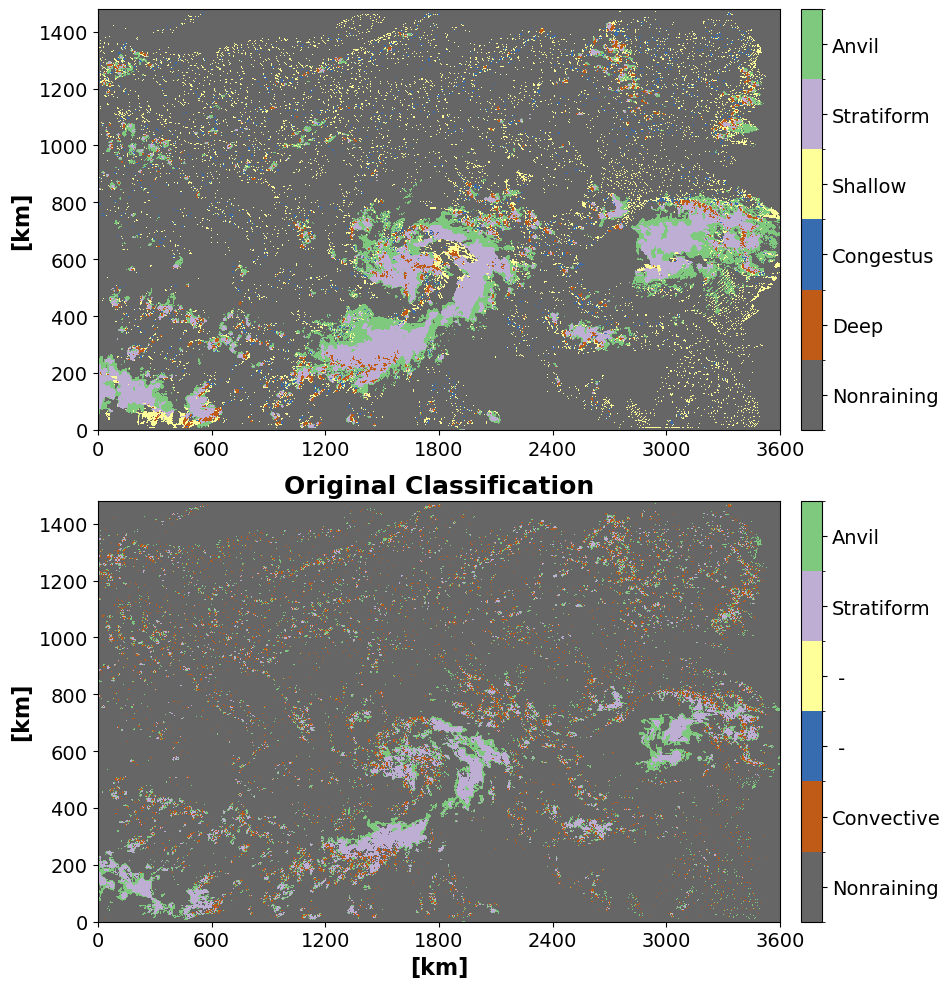

In [17]:
# Horizontal maps

cmin = 0.; cmax = 6; cint = 1 #cmax=5
bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
nlevs = len(bounds) - 1
# cmap = plt.get_cmap('plasma', nlevs)
cmap = plt.get_cmap('Accent_r', nlevs)

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')
ax = fig.add_subplot(211, aspect='equal')

plt.pcolormesh(c_type, cmap=cmap, norm=norm)
cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
# cbar.set_ticks([0.3,1.1,1.85,2.7,3.6,4.5])
cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_xticklabels(np.arange(0,3601,600),fontsize=14)
ax.set_yticklabels(np.arange(0,2221,200),fontsize=14)
ax.set_ylabel('[km]', size=16, weight='bold')

# ax.set_title('Masked Map \n CR_thresh={}, Ice_thresh={}, Graup_thresh={}, Rain_thresh={}'.format(cr_thresh,ice_thresh,graup_thresh,rain_thresh), size=18, weight='bold')

c_type_og2 = np.copy(c_type_og)
c_type_og2[(c_type_og >= 2)] += 2

ax = fig.add_subplot(212,aspect='equal')
# bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5])
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=4)
plt.pcolormesh(c_type_og2, cmap=cmap, norm=norm)
# plt.colorbar(ticks=[0,1,2,3], fraction=0.03, pad=0.04)
cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
# cbar.set_ticks([0.3,1.1,1.85,2.7])
cbar.set_ticklabels(['Nonraining','Convective',' - ',' - ','Stratiform','Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_xticklabels(np.arange(0,3601,600),fontsize=14)
ax.set_yticklabels(np.arange(0,2221,200), fontsize=14)
ax.set_xlabel('[km]', size=16, weight='bold')
ax.set_ylabel('[km]', size=16, weight='bold')
ax.set_title("Original Classification", size=18, weight='bold')
plt.tight_layout()
# plt.savefig('figures/cr_class/masked_cr.png', dpi=300)

#### Avg w profiles

In [18]:
# New classification w mask
precip_list = ['deep', 'shallow', 'congestus', 'stratiform', 'anvil']
# w_wind_mask = np.empty((4,20,740,1200))
# w_wind_mask = np.empty((5,20,740,1200))
w_profile = np.empty((5,nz))
for t in range(np.size(precip_list)):

    ind = (c_type == t+1).nonzero()
    w_profile[t,:] = np.mean(w_wind[:,ind[0],ind[1]],axis=1)
    # not_cloud = (c_type!=(t+1)) # convection
    # w_wind_mask[t] = w_wind.copy()
    # w_wind_mask[t,:,not_cloud==True] = np.nan

# I,J,K,L = np.shape(w_wind_mask)
# w_wind_mask = np.reshape(w_wind_mask,(I,J,K*L))
# w_profile = np.nanmean(w_wind_mask, axis=2)
w_conv = w_profile[0]+w_profile[1]+w_profile[2] # convective total
w_strat = w_profile[3]+w_profile[4] # stratiform total

In [19]:
# Rosi classification w mask
precip_list = ['conv', 'strat', 'mixed']
# w_wind_mask_og = np.empty((3,20,740,1200))
w_profile_og = np.empty((3,nz))
for t in range(np.size(precip_list)):
    ind = (c_type_og == t+1).nonzero()
    w_profile_og[t,:] = np.mean(w_wind[:,ind[0],ind[1]],axis=1)
    # not_cloud = (c_type_og!=(t+1))
    # w_wind_mask_og[t] = w_wind.copy()
    # w_wind_mask_og[t,:,not_cloud==True] = np.nan

# I,J,K,L = np.shape(w_wind_mask_og)
# w_wind_mask_og = np.reshape(w_wind_mask_og,(I,J,K*L))
# w_profile_og = np.nanmean(w_wind_mask_og, axis=2)

Text(0.5, 0, 'w [m/s]')

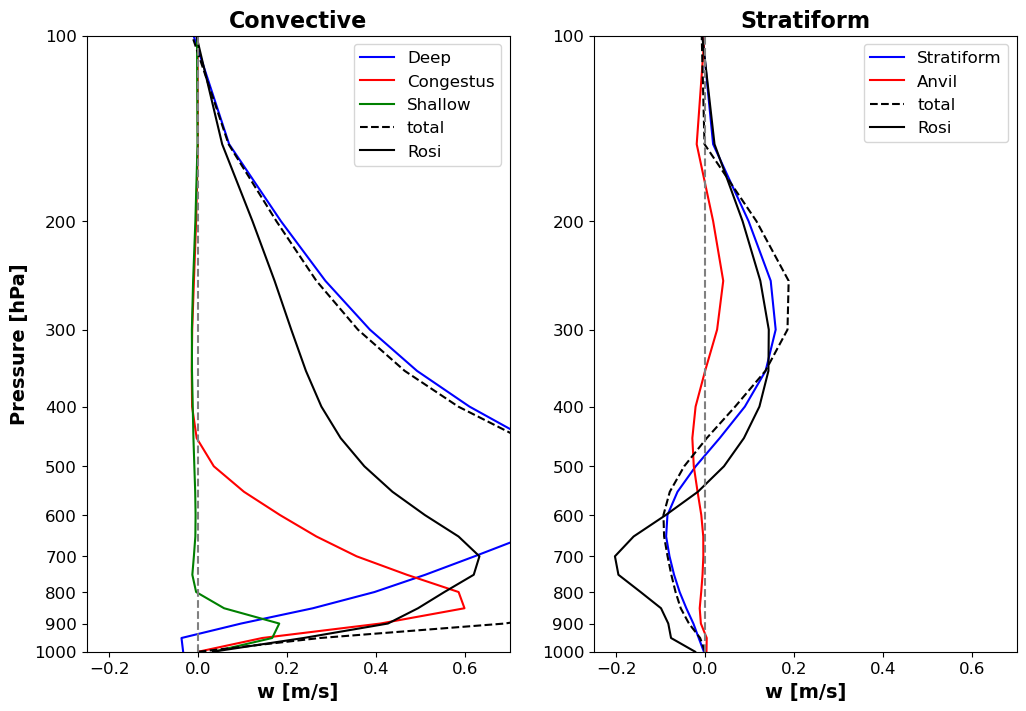

In [20]:
# w profile
fig = plt.figure(figsize=(12,8),facecolor='white')

ax = fig.add_subplot(121)
ax.plot(w_profile[0], pres, label='Deep', color='blue')
ax.plot(w_profile[1], pres, label='Congestus', color='red')
ax.plot(w_profile[2], pres, label='Shallow', color='green')
ax.plot(w_conv, pres, label='total', linestyle='--', color='black')
ax.plot(w_profile_og[0], pres, label='Rosi', color='black')
ax.set_title('Convective', size=16, weight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)#np.min(pres))
plt.xlim(-0.25,0.7)
plt.xticks(size=12)
# ax.ticklabel_format(useOffset=False, axis='y', style='plain')
# plt.ticklabel_format(style='plain')
plt.xlabel('w [m/s]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

ax = fig.add_subplot(122)
ax.plot(w_profile[3], pres, label='Stratiform', color='blue')
ax.plot(w_profile[4], pres, label='Anvil', color='red')
ax.plot(w_strat, pres, label='total', linestyle='--', color='black')
ax.plot(w_profile_og[1], pres, label='Rosi', color='black')
ax.set_title('Stratiform', size=16, weight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
plt.ylim(1000,100)
plt.xlim(-0.25,0.7)
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)#np.min(pres))
plt.xticks(size=12)
# ax.ticklabel_format(useOffset=False, axis='y')
# plt.ticklabel_format(style='plain')
plt.xlabel('w [m/s]', size=14, weight='bold')
# plt.ylabel('Pressure [hPa]', size=14, weight='bold')

# plt.suptitle('CR_thresh={}, Ice_thresh={}, Graup_thresh={}, Rain_thresh={}'.format(cr_thresh,ice_thresh,graup_thresh,rain_thresh), size=18, weight='bold')
# plt.savefig('figures/cr_class/wprofiles_cr0.8_gr5e3_rn.001.png', dpi=300)

#### Avg QRAD profiles

In [21]:
# New classification CRF mask
precip_list = ['deep', 'shallow', 'congestus', 'stratiform', 'anvil']
# w_wind_mask = np.empty((4,20,740,1200))
# w_wind_mask = np.empty((5,20,740,1200))
crf_profile = np.empty((5,nz))
for t in range(np.size(precip_list)):

    ind = (c_type == t+1).nonzero()
    crf_profile[t,:] = np.mean(crf[:,ind[0],ind[1]],axis=1)
    # not_cloud = (c_type!=(t+1)) # convection
    # w_wind_mask[t] = w_wind.copy()
    # w_wind_mask[t,:,not_cloud==True] = np.nan

# I,J,K,L = np.shape(w_wind_mask)
# w_wind_mask = np.reshape(w_wind_mask,(I,J,K*L))
# w_profile = np.nanmean(w_wind_mask, axis=2)
crf_conv = crf_profile[0]+crf_profile[1]+crf_profile[2] # convective total
crf_strat = crf_profile[3]+crf_profile[4] # stratiform total

In [22]:
# Rosi classification CRF mask
precip_list = ['conv', 'strat', 'mixed']
# w_wind_mask_og = np.empty((3,20,740,1200))
crf_profile_og = np.empty((3,nz))
for t in range(np.size(precip_list)):
    ind = (c_type_og == t+1).nonzero()
    crf_profile_og[t,:] = np.mean(crf[:,ind[0],ind[1]],axis=1)
    # not_cloud = (c_type_og!=(t+1))
    # w_wind_mask_og[t] = w_wind.copy()
    # w_wind_mask_og[t,:,not_cloud==True] = np.nan

# I,J,K,L = np.shape(w_wind_mask_og)
# w_wind_mask_og = np.reshape(w_wind_mask_og,(I,J,K*L))
# w_profile_og = np.nanmean(w_wind_mask_og, axis=2)

Text(0.5, 0, 'CRF [K/day]')

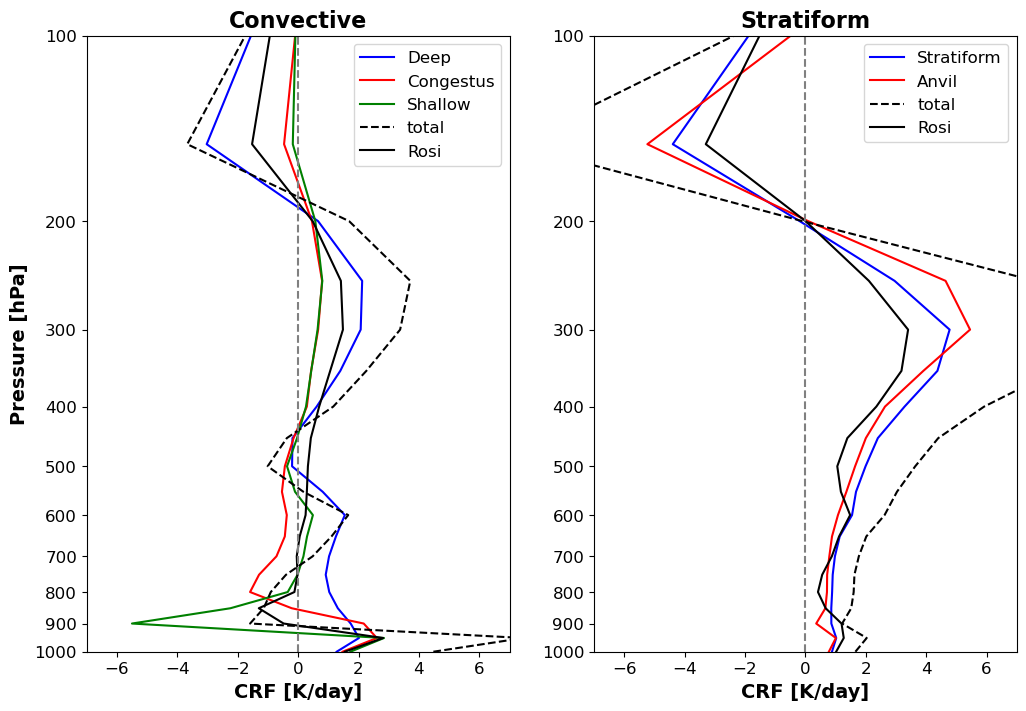

In [23]:
# CRF profile
fig = plt.figure(figsize=(12,8),facecolor='white')

ax = fig.add_subplot(121)
ax.plot(crf_profile[0], pres, label='Deep', color='blue')
ax.plot(crf_profile[1], pres, label='Congestus', color='red')
ax.plot(crf_profile[2], pres, label='Shallow', color='green')
ax.plot(crf_conv, pres, label='total', linestyle='--', color='black')
ax.plot(crf_profile_og[0], pres, label='Rosi', color='black')
ax.set_title('Convective', size=16, weight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)#np.min(pres))
plt.xlim(-7,7)
plt.xticks(size=12)
# ax.ticklabel_format(useOffset=False, axis='y', style='plain')
# plt.ticklabel_format(style='plain')
plt.xlabel('CRF [K/day]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

ax = fig.add_subplot(122)
ax.plot(crf_profile[3], pres, label='Stratiform', color='blue')
ax.plot(crf_profile[4], pres, label='Anvil', color='red')
ax.plot(crf_strat, pres, label='total', linestyle='--', color='black')
ax.plot(crf_profile_og[1], pres, label='Rosi', color='black')
ax.set_title('Stratiform', size=16, weight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
plt.ylim(1000,100)
plt.xlim(-7,7)
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)#np.min(pres))
plt.xticks(size=12)
# ax.ticklabel_format(useOffset=False, axis='y')
# plt.ticklabel_format(style='plain')
plt.xlabel('CRF [K/day]', size=14, weight='bold')
# plt.ylabel('Pressure [hPa]', size=14, weight='bold')

# plt.suptitle('CR_thresh={}, Ice_thresh={}, Graup_thresh={}, Rain_thresh={}'.format(cr_thresh,ice_thresh,graup_thresh,rain_thresh), size=18, weight='bold')
# plt.savefig('figures/cr_class/wprofiles_cr0.8_gr5e3_rn.001.png', dpi=300)

In [24]:
# New classification QCLOUD mask
precip_list = ['deep', 'shallow', 'congestus', 'stratiform', 'anvil']
# Profiles of total cloud
qliq = q_var[1]+q_var[2]+q_var[3] # [kg/kg]; ice + snow + graupel
qice = q_var[4]+q_var[5] # [kg/kg]; cloud + rain
qtot = qliq+qice
qtot*=1e3
q_profile = np.empty((5,nz))
for t in range(np.size(precip_list)):

    ind = (c_type == t+1).nonzero()
    q_profile[t,:] = np.mean(qtot[:,ind[0],ind[1]],axis=1)

q_conv = q_profile[0]+q_profile[1]+q_profile[2] # convective total
q_strat = q_profile[3]+q_profile[4] # stratiform total

In [25]:
# Rosi classification w mask
precip_list = ['conv', 'strat', 'mixed']
q_profile_og = np.empty((3,nz))
for t in range(np.size(precip_list)):
    ind = (c_type_og == t+1).nonzero()
    q_profile_og[t,:] = np.mean(qtot[:,ind[0],ind[1]],axis=1)

Text(0.5, 0, 'Qtotal [g/kg]')

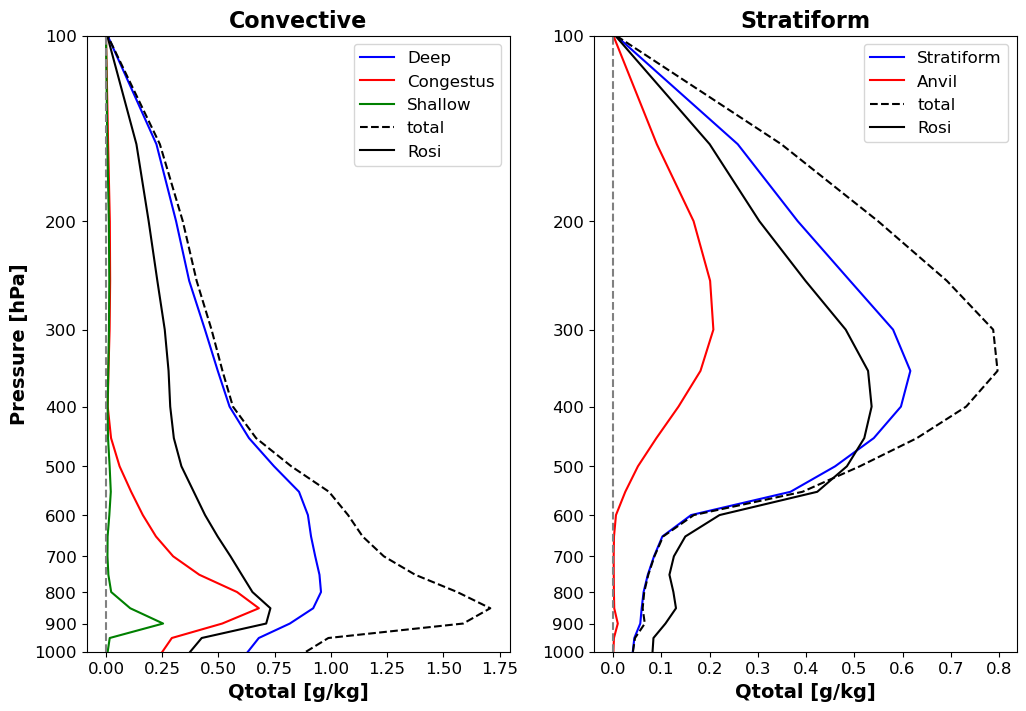

In [26]:
# QTOTAL profile
fig = plt.figure(figsize=(12,8),facecolor='white')

ax = fig.add_subplot(121)
ax.plot(q_profile[0], pres, label='Deep', color='blue')
ax.plot(q_profile[1], pres, label='Congestus', color='red')
ax.plot(q_profile[2], pres, label='Shallow', color='green')
ax.plot(q_conv, pres, label='total', linestyle='--', color='black')
ax.plot(q_profile_og[0], pres, label='Rosi', color='black')
ax.set_title('Convective', size=16, weight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)#np.min(pres))
# plt.xlim(-0.25,0.7)
plt.xticks(size=12)
# ax.ticklabel_format(useOffset=False, axis='y', style='plain')
# plt.ticklabel_format(style='plain')
plt.xlabel('Qtotal [g/kg]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

ax = fig.add_subplot(122)
ax.plot(q_profile[3], pres, label='Stratiform', color='blue')
ax.plot(q_profile[4], pres, label='Anvil', color='red')
ax.plot(q_strat, pres, label='total', linestyle='--', color='black')
ax.plot(q_profile_og[1], pres, label='Rosi', color='black')
ax.set_title('Stratiform', size=16, weight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
plt.ylim(1000,100)
# plt.xlim(-0.25,0.7)
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)#np.min(pres))
plt.xticks(size=12)
# ax.ticklabel_format(useOffset=False, axis='y')
# plt.ticklabel_format(style='plain')
plt.xlabel('Qtotal [g/kg]', size=14, weight='bold')
# plt.ylabel('Pressure [hPa]', size=14, weight='bold')

# plt.suptitle('CR_thresh={}, Ice_thresh={}, Graup_thresh={}, Rain_thresh={}'.format(cr_thresh,ice_thresh,graup_thresh,rain_thresh), size=18, weight='bold')
# plt.savefig('figures/cr_class/wprofiles_cr0.8_gr5e3_rn.001.png', dpi=300)